<a href="https://colab.research.google.com/github/nikitamuntian/study/blob/main/note_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [19]:
# Загрузка данных
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/content/casco_train.csv')
print(data.info())
print(data.isnull().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24511 entries, 0 to 24510
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   column_1   24511 non-null  int64  
 1   column_2   24425 non-null  float64
 2   column_3   24511 non-null  object 
 3   column_4   24511 non-null  object 
 4   column_5   24511 non-null  object 
 5   column_6   24511 non-null  float64
 6   column_7   24511 non-null  object 
 7   column_8   24511 non-null  float64
 8   column_9   24511 non-null  int64  
 9   column_10  24511 non-null  float64
 10  column_11  24511 non-null  int64  
 11  column_12  24511 non-null  int64  
 12  column_13  24511 non-null  float64
 13  column_14  24511 non-null  int64  
 14  column_15  24511 non-null  object 
 15  column_16  24511 non-null  int64  
 16  column_17  24511 non-null  object 
 1

In [20]:
# Заполнение пропусков: для числовых признаков можно использовать медиану, для категориальных – константу
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        data[col].fillna('Unknown', inplace=True)

print(data.isnull().sum())

column_1     0
column_2     0
column_3     0
column_4     0
column_5     0
column_6     0
column_7     0
column_8     0
column_9     0
column_10    0
column_11    0
column_12    0
column_13    0
column_14    0
column_15    0
column_16    0
column_17    0
column_18    0
target       0
dtype: int64


<ipython-input-20-d0f65569c7aa>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-20-d0f65569c7aa>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [21]:
# Разделение на таргет и признаки
y = data['target']
x = data.drop(columns=['target'])

In [22]:
# Кодирование категориальных признаков
x_encoded = pd.get_dummies(x, drop_first=True)

In [23]:
# Разбиение выборки
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

In [24]:
# Масштабирование числовых признаков
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [25]:
# Обучение модели: Ridge регрессия
model = Ridge(alpha=1.0)
model.fit(x_train_scaled, y_train)

Ridge()

In [26]:
# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, x_train_scaled, y_train, scoring='neg_mean_absolute_percentage_error', cv=kf)
print("CV MAPE: ", -np.mean(cv_scores) * 100)

CV MAPE:  24.312270566399018


In [27]:
# Предсказание на тестовой выборке
y_pred = model.predict(x_test_scaled)
print('MAPE (test) = ', mean_absolute_percentage_error(y_test, y_pred) * 100)
print('RMSE (test) = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R² (test) = ', r2_score(y_test, y_pred))

MAPE (test) =  24.00973745367644
RMSE (test) =  287735.3650674671
R² (test) =  0.791794183663592


In [28]:
# Визуализация: scatter plot предсказаний
import plotly.express as px
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df['Error'] = np.abs(results_df['Actual'] - results_df['Predicted'])

fig = px.scatter(results_df, x='Actual', y='Predicted', color='Error', size='Error',
                 title='Сравнение фактической и предсказанной страховой стоимости',
                 labels={'Actual': 'Фактическая стоимость', 'Predicted': 'Предсказанная стоимость'})
fig.add_shape(type='line', x0=results_df['Actual'].min(), y0=results_df['Actual'].min(),
              x1=results_df['Actual'].max(), y1=results_df['Actual'].max(),
              line=dict(color='red', dash='dash'))
fig.show()

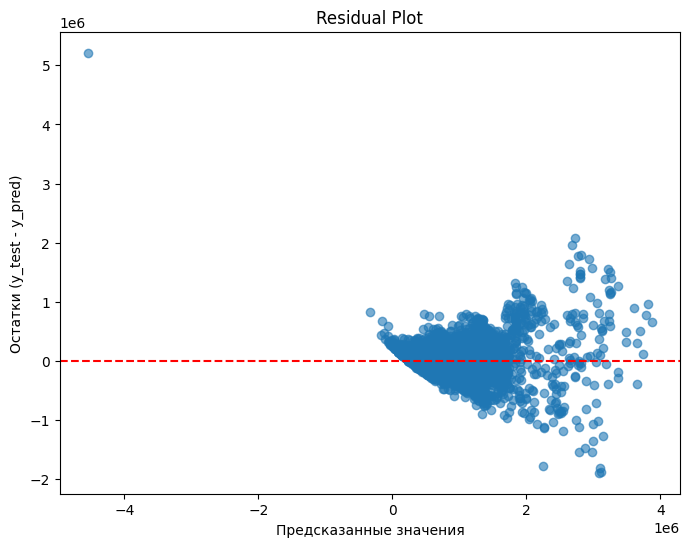

In [29]:
# Визуализация: residual plot
plt.figure(figsize=(8,6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки (y_test - y_pred)')
plt.title('Residual Plot')
plt.show()